In [1]:
# %%
# --- Core Libraries ---
import os
import glob
import cv2
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

!pip install segmentation_models_pytorch
# --- Model & Augmentation Libraries ---
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
# %%
# --- 1. PATHS (Modify these for your setup) ---
# Path to the folder containing the images you want to analyze
IMAGE_FOLDER_PATH = "/content/drive/MyDrive/Work/NotebookData/For_analysis"

# Path to the trained model file (.pth) saved from the training notebook
MODEL_PATH = "/content/drive/MyDrive/Work/NotebookData/Model/best_model.pth"

# Path to the directory where results  will be saved
OUTPUT_DIR = "/content/drive/MyDrive/Work/NotebookData/For_analysis/inference_results"


# --- 2. MODEL PARAMETERS (These MUST match the model you are loading) ---
MODEL_ARC = "Unet"
ENCODER = "resnet34"
ENCODER_WEIGHTS = "imagenet"

# --- 3. PREPROCESSING PARAMETERS (These MUST match how the model was trained) ---
# Image dimensions the model was trained on
IMG_HEIGHT = 1024
IMG_WIDTH = 1024
# Number of channels in the *source* images (1 for grayscale, 3 for color).
INPUT_CHANNELS_CONFIG = 3

# --- 4. INFERENCE PARAMETERS ---
# Probability threshold to convert model output to a binary mask
PREDICTION_THRESHOLD = 0.5
# Set to None if unknown.
PIXEL_RESOLUTION_UM_PER_PX = None

# --- End of User Configuration ---

# --- Setup & Verification ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Verify paths
if not os.path.isdir(IMAGE_FOLDER_PATH):
    raise FileNotFoundError(f"ERROR: Image folder not found at '{IMAGE_FOLDER_PATH}'")
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"ERROR: Model file not found at '{MODEL_PATH}'")

print(f"Configuration Loaded:")
print(f"  Image Folder: {IMAGE_FOLDER_PATH}")
print(f"  Model Path: {MODEL_PATH}")
print(f"  Output Directory: {OUTPUT_DIR}")
print(f"  Using Device: {DEVICE}")

Configuration Loaded:
  Image Folder: /content/drive/MyDrive/Work/NotebookData/For_analysis
  Model Path: /content/drive/MyDrive/Work/NotebookData/Model/best_model.pth
  Output Directory: /content/drive/MyDrive/Work/NotebookData/For_analysis/inference_results
  Using Device: cpu


In [3]:
# %%
def get_inference_augs(height, width):
    """Defines transformations for inference (resizing)."""
    return A.Compose([
        A.Resize(height, width, interpolation=cv2.INTER_LINEAR, always_apply=True),
    ])

def get_preprocessing(preprocessing_fn):
    """Combines model-specific normalization with tensor conversion."""
    _transform = [
        A.Lambda(image=preprocessing_fn),
        ToTensorV2(),
    ]
    return A.Compose(_transform)

In [4]:
# %%
print("Loading trained model...")


try:
    # Instantiate the model with the same architecture as during training
    inference_model = smp.create_model(
        arch=MODEL_ARC,
        encoder_name=ENCODER,
        encoder_weights=None, # We load our own trained weights, not the original imagenet ones
        in_channels=INPUT_CHANNELS_CONFIG,
        classes=1, # Assuming binary segmentation
        activation=None, # We'll apply sigmoid manually to get probability map
    )
    # Load the saved state dictionary
    inference_model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    inference_model.to(DEVICE)
    inference_model.eval() # Set model to evaluation mode (very important!)
    print("Model loaded successfully and set to evaluation mode.")
except Exception as e:
    print(f"Error creating or loading model: {e}")
    print("Please ensure MODEL_ARC and ENCODER parameters in Cell 2 are correct.")
    raise e

# Get the preprocessing function associated with the loaded model's encoder
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
print("Preprocessing function loaded.")

Loading trained model...
Model loaded successfully and set to evaluation mode.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Preprocessing function loaded.


In [5]:
# %%
# --- Prepare for collecting results ---
all_detected_properties = []
visualization_samples = []
NUM_SAMPLES_TO_VISUALIZE = 3 # How many example images to display at the end

# Get preprocessing pipelines
inference_augs_pipeline = get_inference_augs(IMG_HEIGHT, IMG_WIDTH)
preprocessing_pipeline = get_preprocessing(preprocessing_fn)

# Find all images in the folder
image_paths = glob.glob(os.path.join(IMAGE_FOLDER_PATH, '*'))
image_paths = [p for p in image_paths if p.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]

if not image_paths:
    print(f"Error: No images found in '{IMAGE_FOLDER_PATH}'.")
else:
    print(f"\nFound {len(image_paths)} images to process. Starting batch inference...")
    # --- Loop through images ---
    for img_path in tqdm(image_paths, desc="Processing Images"):
        try:
            # 1. Load Original Image
            original_image_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if original_image_bgr is None: continue
            original_image_rgb = cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2RGB)
            original_h, original_w = original_image_rgb.shape[:2]

            # 2. Preprocess Image (consistent with training)
            image_for_model = original_image_rgb.copy()

            augmented = inference_augs_pipeline(image=image_for_model)
            preprocessed = preprocessing_pipeline(image=augmented['image'])
            input_tensor = preprocessed['image'].unsqueeze(0).to(DEVICE, dtype=torch.float32)

            # 3. Perform Inference
            with torch.no_grad():
                pred_output = inference_model(input_tensor)

            # 4. Post-process Prediction
            pred_probs = torch.sigmoid(pred_output) # Apply sigmoid to get probabilities
            pred_prob_map = pred_probs.squeeze().cpu().numpy()
            pred_mask_binary = (pred_prob_map > PREDICTION_THRESHOLD).astype(np.uint8)
            pred_mask_resized = cv2.resize(pred_mask_binary, (original_w, original_h), interpolation=cv2.INTER_NEAREST)

            # 5. Analyze Predicted Mask
            output_cc = cv2.connectedComponentsWithStats(pred_mask_resized, 8, cv2.CV_32S)
            num_labels = output_cc[0]
            stats = output_cc[2]
            centroids = output_cc[3]

            for i in range(1, num_labels): # Skip background label 0
                track_props = {
                    "image_filename": os.path.basename(img_path), "track_id": i,
                    "area_px": stats[i, cv2.CC_STAT_AREA],
                    "centroid_x_px": round(centroids[i][0], 1), "centroid_y_px": round(centroids[i][1], 1),
                }
                if PIXEL_RESOLUTION_UM_PER_PX is not None:
                    track_props["area_um2"] = round(track_props["area_px"] * (PIXEL_RESOLUTION_UM_PER_PX**2), 2)
                all_detected_properties.append(track_props)

            # Save a few samples for visualization at the end
            if len(visualization_samples) < NUM_SAMPLES_TO_VISUALIZE:
                visualization_samples.append({
                    "original": original_image_rgb,
                    "predicted_mask": pred_mask_resized,
                    "filename": os.path.basename(img_path)
                })

        except Exception as e_loop:
            print(f"Error processing image {os.path.basename(img_path)}: {e_loop}")
            continue

    print("Batch inference complete.")


Found 59 images to process. Starting batch inference...


/tmp/ipython-input-3-3108267752.py:5: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height, width, interpolation=cv2.INTER_LINEAR, always_apply=True),


Processing Images:   0%|          | 0/59 [00:00<?, ?it/s]

Batch inference complete.



--- Aggregated Results ---
Total tracks found across all images: 3273
Sample of detected track properties:


,image_filename,track_id,area_px,centroid_x_px,centroid_y_px
0,WIN_20221104_16_53_46_Pro.jpg,1,2805,1097.8,70.2
1,WIN_20221104_16_53_46_Pro.jpg,2,3170,475.5,102.6
2,WIN_20221104_16_53_46_Pro.jpg,3,943,20.8,195.1
3,WIN_20221104_16_53_46_Pro.jpg,4,3414,2192.4,213.4
4,WIN_20221104_16_53_46_Pro.jpg,5,2369,1737.9,240.9


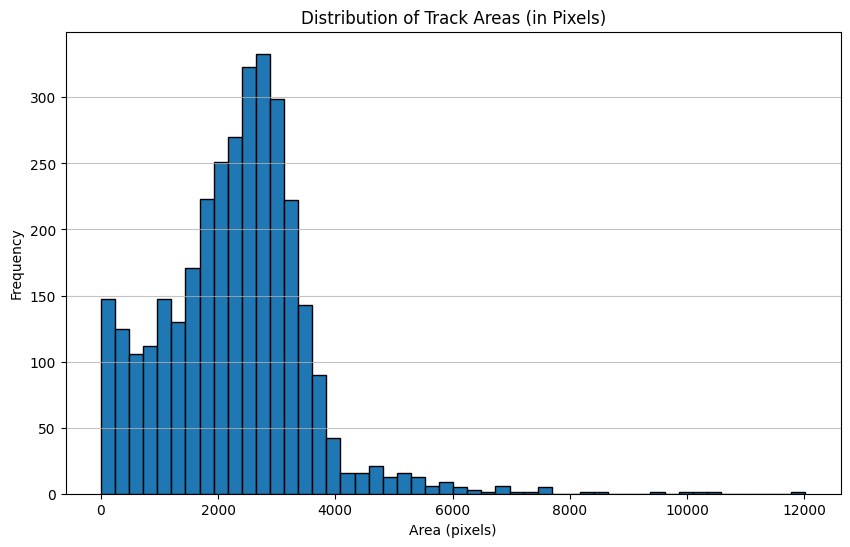


Full results saved to: /content/drive/MyDrive/Work/NotebookData/For_analysis/inference_results/detected_track_properties.csv


In [9]:
    # %%
if not all_detected_properties:
  print("\nNo tracks were detected in any of the processed images.")
else:
    # --- Create and Display DataFrame ---
  properties_df = pd.DataFrame(all_detected_properties)
  print(f"\n--- Aggregated Results ---")

  print(f"Total tracks found across all images: {len(properties_df)}")
  print("Sample of detected track properties:")
  display(properties_df.head())

  plt.figure(figsize=(10, 6))
  plt.hist(properties_df['area_px'], bins=50, edgecolor='black') # You can adjust the number of bins
  plt.title('Distribution of Track Areas (in Pixels)')
  plt.xlabel('Area (pixels)')
  plt.ylabel('Frequency')
  plt.grid(axis='y', alpha=0.75)
  plt.show()

  # --- Save to CSV ---
  csv_output_path = os.path.join(OUTPUT_DIR, "detected_track_properties.csv")
  properties_df.to_csv(csv_output_path, index=False)
  print(f"\nFull results saved to: {csv_output_path}")


--- Example Visualizations with Overlays ---


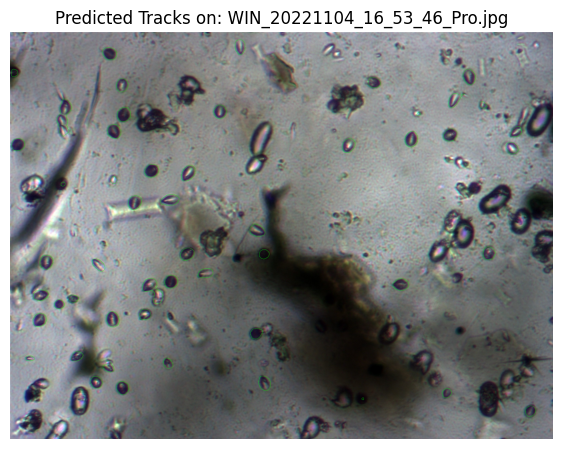

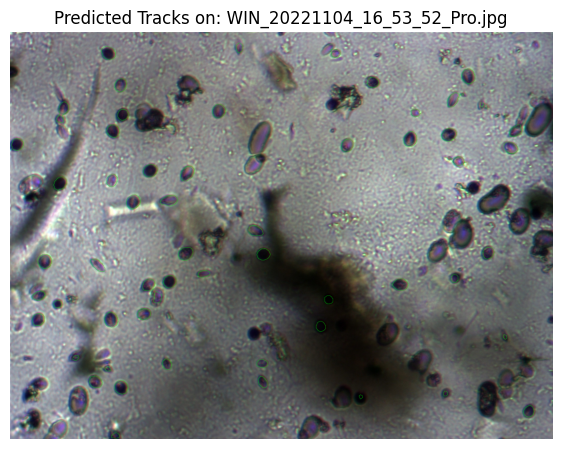

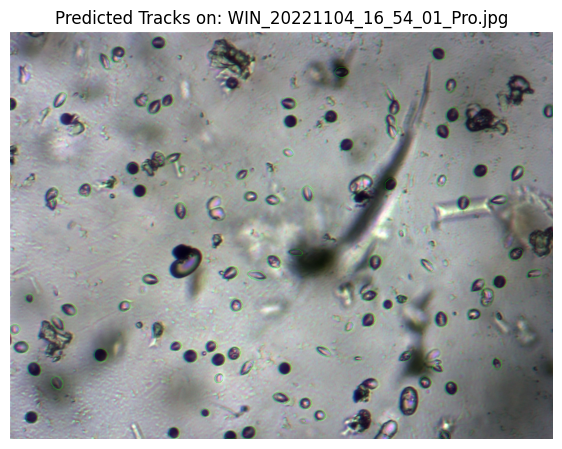

In [10]:
# %%
if not visualization_samples:
    print("\nNo samples were saved for visualization.")
else:
    print("\n--- Example Visualizations with Overlays ---")
    for sample in visualization_samples:
        original_img = sample["original"]
        pred_mask = sample["predicted_mask"]
        filename = sample["filename"]

        # Create overlay image
        overlay = original_img.copy()
        contours, _ = cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, (0, 255, 0), 1) # Draw contours in green

        # Display the result
        plt.figure(figsize=(7, 7))
        plt.imshow(overlay)
        plt.title(f"Predicted Tracks on: {filename}")
        plt.axis('off')
        plt.show()